In [13]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

# Reading and optimizing input files

First we open a list of data types used in reading files, then we concatenate files and check memory usage.

In [14]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

In [15]:
read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

In [16]:
arts_fy11 = pd.read_csv('../input/ARTS_Passenger_Data_FY11.csv.gz', **read_csv_opts)
arts_fy12 = pd.read_csv('../input/ARTS_Passenger_Data_FY12.csv.gz', **read_csv_opts)
arts_fy13 = pd.read_csv('../input/ARTS_Passenger_Data_FY13.csv.gz', **read_csv_opts)
arts_fy14 = pd.read_csv('../input/ARTS_Passenger_Data_FY14.csv.gz', **read_csv_opts)
arts_fy15 = pd.read_csv('../input/ARTS_Passenger_Data_FY15.csv.gz', **read_csv_opts)
arts_fy16 = pd.read_csv('../input/ARTS_Passenger_Data_FY16.csv.gz', **read_csv_opts)
arts_fy17 = pd.read_csv('../input/ARTS_Passenger_Data_FY17.csv.gz', **read_csv_opts)
arts_fy18 = pd.read_csv('../input/ARTS_Passenger_Data_FY18.csv.gz', **read_csv_opts)
arts_fy19 = pd.read_csv('../input/ARTS_Passenger_Data_FY19.csv.gz', **read_csv_opts)

In [17]:
arts_fy11.head()

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionDate,MissionNumber,PULOC,DropLoc,...,air_Country,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country
0,Removal,MALE,Non-Criminal,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
1,Removal,MALE,Non-Criminal,No,1.0,38.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
2,Removal,MALE,Non-Criminal,No,1.0,20.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
3,Removal,MALE,Non-Criminal,No,1.0,29.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
4,Removal,MALE,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala


In [18]:
files = [arts_fy11,
         arts_fy12,
         arts_fy13,
         arts_fy14,
         arts_fy15,
         arts_fy16,
         arts_fy17,
         arts_fy18,
         arts_fy19]

In [19]:
# Concatenating DataFrames converts 'category' columns back to 'object' when new values introduced
df = pd.concat(files)

In [20]:
df_obj = df.select_dtypes(include=['object']).copy()

In [21]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]

In [22]:
df[converted_obj.columns] = converted_obj

In [23]:
# df = df.drop(['index'], axis=1)

# Analyze

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1763020 entries, 0 to 37258
Data columns (total 43 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                category
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City       

In [25]:
df.head()

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionDate,MissionNumber,PULOC,DropLoc,...,air_Country,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country
0,Removal,MALE,Non-Criminal,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
1,Removal,MALE,Non-Criminal,No,1.0,38.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
2,Removal,MALE,Non-Criminal,No,1.0,20.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
3,Removal,MALE,Non-Criminal,No,1.0,29.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
4,Removal,MALE,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala


In [26]:
df.loc[0]

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionDate,MissionNumber,PULOC,DropLoc,...,air_Country,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country
0,Removal,MALE,Non-Criminal,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,USA,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala
0,TRANSFER,MALE,DUI,NaN,1.0,30.0,2011-10-01,120001,KIWA,KBFI,...,USA,39.0,Boeing Field King County International Airport,Seattle,51.0,WA,22.0,SEA,Seattle,USA
0,RM,FEMALE,NC,N,NaN,21.0,2012-10-01,130005,KMIA,MHLM,...,USA,150.0,Ramon Villeda Morales International Airport,San Pedro Sula,NaN,NaN,NaN,NaN,NaN,Honduras
0,NaN,MALE,NaN,N,1.0,33.0,2013-10-01,140003,KELP,mmmx,...,USA,155.0,Licenciado Benito Juarez International Airport,Mexico City,NaN,NaN,NaN,NaN,NaN,Mexico
0,8F,MALE,IE,N,NaN,19.0,2014-10-01,150005,KSAT,MSLP,...,USA,157.0,El Salvador International Airport,San Salvador,NaN,NaN,NaN,NaN,NaN,El Salvador
0,16,M,Other - Non-Violent,N,NaN,27.0,2015-10-01,160001,KIWA,KELP,...,USA,57.0,El Paso International Airport,El Paso,46.0,TX,9.0,ELP,El Paso,USA
0,8G,M,NC,N,NaN,26.0,2016-12-22,170443,KMIA,KAEX,...,USA,35.0,Alexandria International Airport,Alexandria,20.0,LA,13.0,NOL,New Orleans,USA
0,8C,M,Drug Possession,N,NaN,22.0,2017-10-20,180072,KAEX,MHLM,...,USA,150.0,Ramon Villeda Morales International Airport,San Pedro Sula,NaN,NaN,NaN,NaN,NaN,Honduras
0,8C,F,NC,N,NaN,38.0,2018-10-01,190009,KATL,KBRO,...,USA,45.0,Brownsville South Padre Island International A...,Brownsville,46.0,TX,19.0,SNA,San Antonio,USA


In [27]:
len(df)

1763020

No missing values in ID fields. IDs repeat.

In [28]:
len(set(df['MissionID']))

14973

In [29]:
sum(df['MissionID'].isnull())

0

In [30]:
len(set(df['AlienMasterID']))

1733555

In [31]:
sum(df['AlienMasterID'].isnull())

0

In [32]:
df['MissionDate'].min()

Timestamp('2010-10-01 00:00:00')

In [33]:
df['MissionDate'].max()

Timestamp('2018-12-05 00:00:00')

In [34]:
df.set_index('MissionDate', inplace=True)

Top pickup airports.

In [35]:
df['air_AirportName'].value_counts().head(10)

Alexandria International Airport                        239911
Brownsville South Padre Island International Airport    204895
Phoenix-Mesa-Gateway Airport                            196150
Valley International Airport                            154138
El Paso International Airport                           136127
San Antonio International Airport                       107434
Columbus Metropolitan Airport                            80797
Harrisburg International Airport                         76348
Laredo International Airport                             56409
Miami International Airport                              55588
Name: air_AirportName, dtype: int64

Top dropoff airports.

In [36]:
df['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                       327010
Ramon Villeda Morales International Airport             202955
Alexandria International Airport                        169316
El Salvador International Airport                       157773
Valley International Airport                            148700
Phoenix-Mesa-Gateway Airport                             93892
El Paso International Airport                            87408
Licenciado Benito Juarez International Airport           85584
Brownsville South Padre Island International Airport     66444
San Diego International Airport                          62943
Name: air2_AirportName, dtype: int64

In [37]:
df['R-T'].value_counts()

Removal       1110458
Transfer       448753
REMOVAL        147703
transfer        28835
TRANSFER        21765
removal          5258
RemovaL           117
reMOVAL           110
Ineligible          2
No-show             1
Name: R-T, dtype: int64

In [38]:
with open('../../share/hand/clean.yaml', 'r') as yamlfile:
    clean = yaml.load(yamlfile)

In [39]:
df['R-T'] = df['R-T'].replace(clean['R-T'])
df['R-T'] = df['R-T'].astype('category')
df['R-T'].value_counts()

R             1263646
T              499353
Ineligible          2
No-show             1
Name: R-T, dtype: int64

In [40]:
df['Sex'] = df['Sex'].replace(clean['Sex'])
df['Sex'] = df['Sex'].astype('category')
df['Sex'].value_counts()

M    1618577
F     144302
U        137
Name: Sex, dtype: int64

In [41]:
df['Criminality'] = df['Criminality'].replace(clean['Criminality'])
df['Criminality'] = df['Criminality'].astype('category')
df['Criminality'].value_counts()
df['NonCriminal'] = df['Criminality'] == 'NC'

In [42]:
# This column had a bunch of random-seeming numeric strings, replace removes any string that's just numbers
# I checked and there were no '13' or '15' or '18' values before replace
# Numeric strings didn't seem to be result of data shifted into column but need to investigate more
df['GangMember'] = df['GangMember'].str.replace('^[0-9]*$', '')
df['GangMember'] = df['GangMember'].astype('category')
df['GangMember'].value_counts()

N                 1079547
No                 243020
NO                 120228
NONE                91863
Y                   10891
None                 8675
no                   5201
                     4960
Yes                  1677
n                    1061
YES                   795
none                  636
NON                   530
None known            355
SURENO                285
MT                    274
MS-13                 118
UNKNOWN                75
LOW                    62
NORTENO                55
SUR                    47
***                    46
Non-Criminal           44
yes                    41
Non-Crim               35
M                      35
CODE 15                26
DENVER                 23
(SURENO)               21
H                      17
                   ...   
SURENO D/O              1
FCO                     1
East L.A.               1
SURENO/CODE 15          1
EPC                     1
EAZ                     1
SURRENO                 1
Delhi       

In [43]:
# This field seems pretty clean, look for duplicates due to spelling or style
df['CountryOfCitizenship'] = df['CountryOfCitizenship'].str.upper()
df['CountryOfCitizenship'] = df['CountryOfCitizenship'].astype('category')
df['CountryOfCitizenship'].value_counts().head(15)

MEXICO                597173
GUATEMALA             421479
HONDURAS              304779
EL SALVADOR           256909
DOMINICAN REPUBLIC     31703
ECUADOR                25692
HAITI                  23308
NICARAGUA              18679
COLOMBIA               14521
JAMAICA                12801
INDIA                   8952
CHINA                   4460
CUBA                    3658
BANGLADESH              2831
SOMALIA                 2668
Name: CountryOfCitizenship, dtype: int64

In [44]:
df['PULOC'] = df['PULOC'].str.upper()
df['PULOC'] = df['PULOC'].astype('category')
df['PULOC'].value_counts().head(15)

KAEX    239911
KBRO    204895
KIWA    196150
KHRL    154138
KELP    136127
KSAT    107434
KCSG     80797
KMDT     76348
KLRD     56409
KMIA     55588
KSAN     53008
KIAH     50378
KOAK     40532
KBFI     34466
KEWR     31218
Name: PULOC, dtype: int64

In [45]:
df['DropLoc'] = df['DropLoc'].str.upper()
df['DropLoc'] = df['DropLoc'].astype('category')
df['DropLoc'].value_counts().head(15)

MGGT    327010
MHLM    202955
KAEX    169316
MSLP    157773
KHRL    148700
KIWA     93892
KELP     87408
MMMX     85584
KBRO     66444
KSAN     62943
KNYL     58124
KLRD     46923
KMIA     22657
KNJK     20356
MHTG     19944
Name: DropLoc, dtype: int64

Status field is very messy, may be interesting?

In [46]:
df['Status'].value_counts().head(15)

16                324026
8F                239232
Removal           229049
8C                169443
8G                129502
RM                 98768
ER                 87668
REMOVAL            63654
VR                 63102
3                  37389
REINST             35197
11                 29086
Transfer - F/O     19596
NTA-TFRD           15633
8A                 13058
Name: Status, dtype: int64

In [47]:
print('Field: # of unique values')
print('-------------------------')
for column in df.columns:
    print(f'{column}: {len(df[column].unique())}')

Field: # of unique values
-------------------------
Status: 1163
Sex: 4
Convictions: 14735
GangMember: 291
ClassLvl: 392
Age: 144
MissionNumber: 14973
PULOC: 84
DropLoc: 208
StrikeFromList: 1
ReasonStruck: 14
R-T: 5
Code: 9
CountryOfCitizenship: 215
Juvenile: 3
MissionWeek: 53
MissionQuarter: 4
MissionYear: 9
MissionMonth: 12
Criminality: 3
FamilyUnitFlag: 1
UnaccompaniedFlag: 1
AlienMasterID: 1733555
MissionID: 14973
air_AirportID: 84
air_AirportName: 83
air_City: 79
st_StateID: 33
st_StateAbbr: 33
AOR_AORID: 24
AOR_AOR: 24
AOR_AORName: 24
air_Country: 11
air2_AirportID: 203
air2_AirportName: 200
air2_City: 195
st2_StateID: 34
st2_StateAbbr: 34
aor2_AORID: 23
aor2_AOR: 23
aor2_AORName: 23
air2_Country: 116
NonCriminal: 2


In [48]:
KBFI_pickup = df['PULOC'] == 'KBFI'
KBFI_dropoff = df['DropLoc'] == 'KBFI'

In [49]:
KBFI_pickups = df[KBFI_pickup]
KBFI_dropoffs = df[KBFI_dropoff]

In [55]:
len(set(KBFI_pickups['AlienMasterID']))

34443

In [56]:
len(set(KBFI_pickups['MissionID']))

466

In [38]:
# KBFI_pickups.set_index('MissionDate', inplace=True)
# KBFI_dropoffs.set_index('MissionDate', inplace=True)

In [39]:
weekly_KBFI_pickups = KBFI_pickups['AlienMasterID'].resample('W').count()
weekly_KBFI_dropoffs = KBFI_dropoffs['AlienMasterID'].resample('W').count()
monthly_KBFI_pickups = KBFI_pickups['AlienMasterID'].resample('M').count()
monthly_KBFI_dropoffs = KBFI_dropoffs['AlienMasterID'].resample('M').count()
annual_KBFI_pickups = KBFI_pickups['2011':'2018']['AlienMasterID'].resample('AS').count()
annual_KBFI_dropoffs = KBFI_dropoffs['2011':'2018']['AlienMasterID'].resample('AS').count()

In [40]:
annual_KBFI_pickups

MissionDate
2011-01-01    6530
2012-01-01    5402
2013-01-01    4626
2014-01-01    3600
2015-01-01    2852
2016-01-01    3178
2017-01-01    3462
2018-01-01    3278
Freq: AS-JAN, Name: AlienMasterID, dtype: int64

In [41]:
annual_KBFI_dropoffs

MissionDate
2011-01-01     708
2012-01-01    1385
2013-01-01    1983
2014-01-01    1943
2015-01-01    2508
2016-01-01    2778
2017-01-01    1451
2018-01-01    2317
Freq: AS-JAN, Name: AlienMasterID, dtype: int64

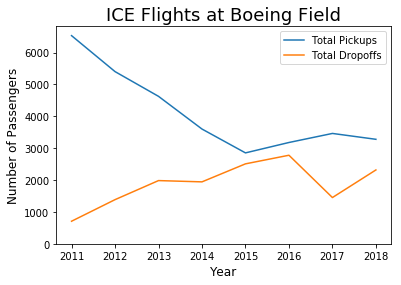

In [42]:
def plot(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=12)
    ax.set_ylim(0)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_title('ICE Flights at Boeing Field', fontsize=18)
    
    fig.savefig('../output/ICEFlights.png')
    return fig, ax

annual_KBFI_pickups.rename('Total Pickups', inplace=True)
annual_KBFI_dropoffs.rename('Total Dropoffs', inplace=True)

plot = plot([annual_KBFI_pickups, annual_KBFI_dropoffs]);

In [43]:
annual_non_criminal = KBFI_pickups[['NonCriminal']].resample('AS').sum()

In [44]:
annual_non_criminal['total'] = annual_KBFI_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_KBFI_pickups*100

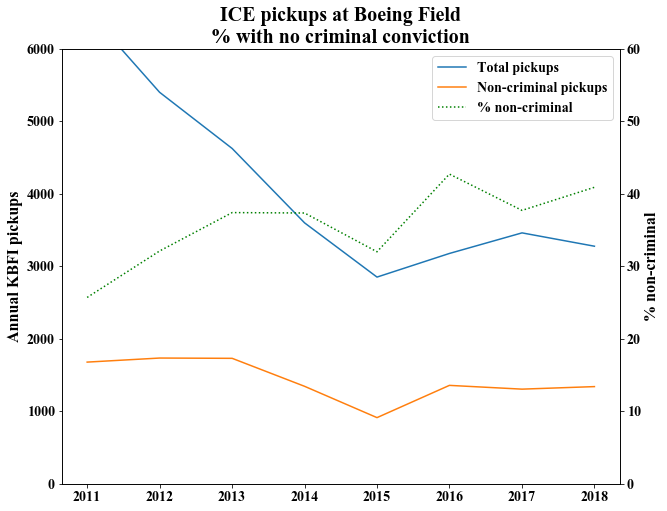

In [45]:
annual_data = annual_non_criminal['2011':'2018']
# monthly_data = monthly_non_criminal

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Times New Roman")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1.set_ylim(0, 7000)
ax1.set_ylabel('Annual KBFI pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2.set_ylim(0,60)
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title('ICE pickups at Boeing Field\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig('../output/NoCrim.png', dpi=100)

# Mapping

In [46]:
df.reset_index(inplace=True)

In [47]:
groupby = df.groupby(['MissionYear', 'R-T', 'PULOC', 'DropLoc'])

In [48]:
table = groupby.size().reset_index()

In [49]:
flights = groupby['MissionID'].nunique().reset_index()['MissionID']

In [50]:
table.columns = ['year', 'R-T', 'pickup_airport', 'dropoff_airport', 'passengers']

In [51]:
table['flights'] = flights

In [52]:
table.reset_index(drop=True, inplace=True)

In [53]:
all_kbfi = (table['pickup_airport'] == 'KBFI') | (table['dropoff_airport'] == 'KBFI')

In [54]:
table.to_csv('../output/flight_summary.csv.gz', index=False, compression='gzip', encoding='utf-8', sep='|')

In [55]:
table

,year,R-T,pickup_airport,dropoff_airport,passengers,flights
0,2010,R,KAEX,KHRL,2025,23
1,2010,R,KAEX,KLRD,27,2
2,2010,R,KAEX,MDSD,549,6
3,2010,R,KAEX,MGGT,1441,13
4,2010,R,KAEX,MHLM,454,5
5,2010,R,KAEX,MHTG,756,8
6,2010,R,KAEX,MKJP,201,3
7,2010,R,KAEX,MSLP,438,5
8,2010,R,KAEX,SEGU,343,6
9,2010,R,KAEX,SKBO,244,3


# Tracking individual

In [56]:
df.columns

Index(['MissionDate', 'Status', 'Sex', 'Convictions', 'GangMember', 'ClassLvl',
       'Age', 'MissionNumber', 'PULOC', 'DropLoc', 'StrikeFromList',
       'ReasonStruck', 'R-T', 'Code', 'CountryOfCitizenship', 'Juvenile',
       'MissionWeek', 'MissionQuarter', 'MissionYear', 'MissionMonth',
       'Criminality', 'FamilyUnitFlag', 'UnaccompaniedFlag', 'AlienMasterID',
       'MissionID', 'air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country', 'air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country', 'NonCriminal'],
      dtype='object')

In [57]:
df.head()

,MissionDate,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionNumber,PULOC,DropLoc,...,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,NonCriminal
0,2010-10-01,Removal,M,Non-Criminal,No,1.0,18.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
1,2010-10-01,Removal,M,Non-Criminal,No,1.0,38.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
2,2010-10-01,Removal,M,Non-Criminal,No,1.0,20.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
3,2010-10-01,Removal,M,Non-Criminal,No,1.0,29.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
4,2010-10-01,Removal,M,Non-Criminal,No,1.0,21.0,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False


In [58]:
count = df.groupby(['AlienMasterID']).size().reset_index(name='count')

In [59]:
count.set_index('AlienMasterID', inplace=True)

In [61]:
df.set_index('AlienMasterID', inplace=True)

In [62]:
df = df.join(count, how='left')

In [63]:
more_than_one = df['count'] > 1

In [64]:
multiple_alienID = df[more_than_one]

In [65]:
multiple_alienID.to_csv('../output/multiple_alienID.csv.gz', compression='gzip', sep='|')

# By nationality

In [85]:
countries = list(df['CountryOfCitizenship'].astype('str').unique())

In [86]:
with open('../output/countries.yaml', 'w') as outfile:
    yaml.dump(countries, outfile, default_flow_style=False)

In [89]:
somali = df['CountryOfCitizenship'] == 'SOMALIA'

In [113]:
somali_df = df[somali]

In [114]:
somali_df.reset_index(inplace=True)

In [115]:
somali_df.head()

,AlienMasterID,MissionDate,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionNumber,PULOC,...,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,NonCriminal,count
0,8788,2010-10-02,ER-Transfer,M,Non-Criminal,NO,1.0,26.0,110046,KIWA,...,Boeing Field King County International Airport,Seattle,51.0,WA,22.0,SEA,Seattle,USA,False,1
1,8799,2010-10-02,ER-NEW,M,Non-Criminal,No,1.0,21.0,110046,KIWA,...,Boeing Field King County International Airport,Seattle,51.0,WA,22.0,SEA,Seattle,USA,False,1
2,8804,2010-10-02,ER-NEW,M,Non-Criminal,No,1.0,26.0,110046,KIWA,...,Boeing Field King County International Airport,Seattle,51.0,WA,22.0,SEA,Seattle,USA,False,1
3,9988,2010-10-01,ER-Transfer,M,Non-Criminal,NO,1.0,26.0,110002,KSAN,...,Phoenix-Mesa-Gateway Airport,Mesa,4.0,AZ,17.0,PHO,Phoenix,USA,False,1
4,10022,2010-10-01,ER-NEW,M,Non-Criminal,No,1.0,21.0,110002,KSAN,...,Phoenix-Mesa-Gateway Airport,Mesa,4.0,AZ,17.0,PHO,Phoenix,USA,False,1


In [127]:
groupby = somali_df.groupby(['MissionDate', 'MissionYear', 'R-T', 'PULOC', 'DropLoc'])

In [128]:
table = groupby.size().reset_index()

In [129]:
somali_repatriations = table[table['R-T'] == 'R']
somali_transfers = table[table['R-T'] == 'T']

In [136]:
somali_transfers.groupby(['MissionYear'])[0].sum()

MissionYear
2010     34
2011     25
2012     65
2013     91
2014    113
2015    401
2016    296
2017    536
2018    527
Name: 0, dtype: int64

In [137]:
somali_repatriations

,MissionDate,MissionYear,R-T,PULOC,DropLoc,0
28,2012-04-15,2012,R,KAEX,HKJK,9
46,2012-11-17,2012,R,KAEX,HKJK,10
124,2014-06-03,2014,R,KMIA,HKJK,2
365,2017-01-24,2017,R,KAEX,HCMM,90
390,2017-03-09,2017,R,KAEX,HCMM,68
411,2017-05-11,2017,R,KAEX,HCMM,67
429,2017-05-25,2017,R,KIWA,HCMM,50
457,2017-07-27,2017,R,KAEX,HCMM,67
529,2018-03-29,2018,R,KELP,HCMM,68
572,2018-06-28,2018,R,KAEX,HCMM,83
